### Sony Data Science - Challenge


<br>

 - Name: Felipe Oliveira da Silva




<br>


#### About the dataset
Introducing a comprehensive treasure trove of cinematic data sourced from IMDB This meticulously curated dataset offers an extensive array of information on movies, spanning titles, release dates, plot outlines, and genres. With its rich repository of film details, researchers, enthusiasts, and industry professionals alike can delve deep into the world of cinema, exploring trends, patterns, and insights that shape the movie landscape. Whether you're analyzing genre evolution or uncovering hidden cinematic gems, this dataset serves as a valuable resource for understanding the diverse tapestry of the film industry.



<br>
<br>
<hr>
<br>


In [1]:
!pip install catboost -q
!pip install shap -q
!pip install pycaret -q
!pip install missingno -q

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import missingno as msno
import shap
import pycaret
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import TargetEncoder

In [3]:
# load dataset
df_train = pd.read_excel('/content/drive/MyDrive/ML-studies/Tests/Sony/dataset/train_set.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/ML-studies/Tests/Sony/dataset/test_set.xlsx')

df_train.head()

,ID,SRC_TITLE_ID,SRC_TITLE_NM,TITLE_TYPE,TITLE_YR,RELEASE_DT,RUN_TIME,PLOT_OUTLINE,PLOT_MEDIUM,PLOT_SUMMARY,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,SRC_GENRE
0,1,tt7831076,"Yes, Sir! 7",movie,2016,2016-09-02,111.0,NaN,"From 1988 to 2000, Taiwan released six Yes, Si...","From 1988 to 2000, Taiwan released six Yes, Si...",1.4,127,NaN,Comedy
1,2,tt14746344,ReSet,movie,2022,2023-07-02,89.0,A college student passes out at a party and wa...,Danielle is your average college student getti...,A college student passes out at a party and wa...,4.3,71,35000.0,Horror
2,3,tt15670842,The Sword,movie,2021,2021-10-18,106.0,"In the ancient times, the Demon King, who was ...",NaN,"In the ancient times, the Demon King, who was ...",4.7,9,NaN,Action
3,4,tt14833900,Around the Table,movie,2021,2021-05-13,104.0,NaN,Haruko is a single mother. She has an unusual ...,Haruko is a single mother. She has an unusual ...,6.0,92,NaN,Drama
4,5,tt10495074,Iqro: My Universe,movie,2019,2019-07-11,101.0,NaN,"Aqilla has aspirations to become an astronaut,...","Aqilla has aspirations to become an astronaut,...",6.8,16,NaN,Adventure


In [4]:
# shape of dataframes
df_train.shape, df_test.shape

((12000, 14), (12000, 13))

In [5]:
# checking columns type
df_train.dtypes

ID                       int64
SRC_TITLE_ID            object
SRC_TITLE_NM            object
TITLE_TYPE              object
TITLE_YR                 int64
RELEASE_DT      datetime64[ns]
RUN_TIME               float64
PLOT_OUTLINE            object
PLOT_MEDIUM             object
PLOT_SUMMARY            object
RATING_AVG             float64
NO_OF_VOTES              int64
BUDGET_AMT             float64
SRC_GENRE               object
dtype: object

<br>
<hr>
<br>
<br>

### 1. Exploratory Analysis


In the machine learning pipeline, exploratory data analysis (EDA) serves as my crucial first step. It's where I immerse myself in the dataset, uncovering its nuances, quirks, and potential patterns. EDA is my compass, guiding me through the vast landscape of data science, helping me understand the story the data wants to tell.

During EDA, I delve deep into the dataset, examining its structure, distributions, and relationships. I seek to understand the distribution of variables, identifying outliers, and understanding their impact. Visualizations become my trusty companions, helping me spot trends, correlations, and anomalies that might otherwise remain hidden.

The importance of EDA cannot be overstated. It lays the foundation for the entire machine learning process, informing feature selection, data preprocessing steps, and even the choice of algorithms. Through EDA, I gain insights that shape my modeling decisions, helping me build more accurate and robust predictive models.

In essence, EDA is my journey of discovery, where I unravel the mysteries of the data and pave the way for meaningful insights and impactful solutions.

<br>
<br>

In [6]:
len(df_train["SRC_GENRE"].value_counts())

23

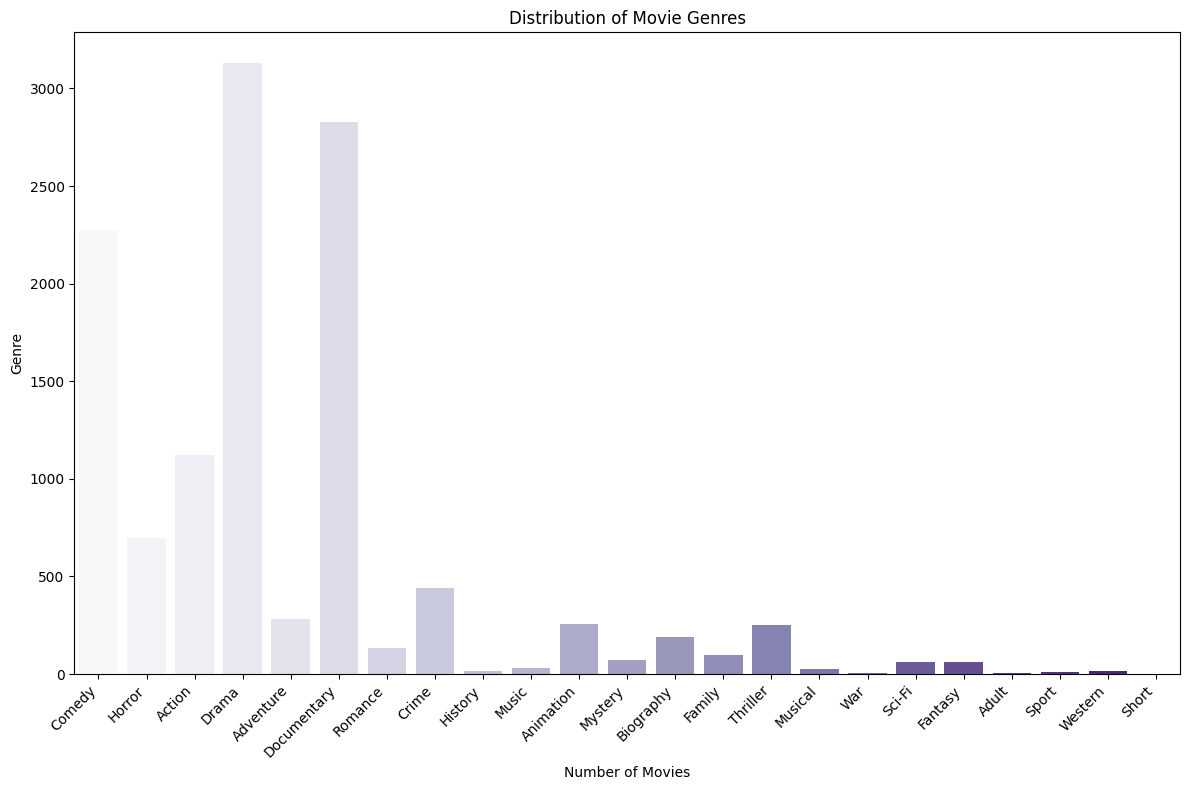





Number of unique movie genres in the dataset: 23
SRC_GENRE
Drama          0.260917
Documentary    0.235750
Comedy         0.189750
Action         0.093333
Horror         0.058000
Crime          0.036667
Adventure      0.023667
Animation      0.021250
Thriller       0.020750
Biography      0.015833
Romance        0.010917
Family         0.008000
Mystery        0.006083
Fantasy        0.005083
Sci-Fi         0.005000
Music          0.002750
Musical        0.002000
Western        0.001333
History        0.001083
Sport          0.000750
War            0.000583
Adult          0.000417
Short          0.000083
Name: proportion, dtype: float64


In [7]:
# Question: How many unique movie genres are in the dataset?
plt.figure(figsize=(12, 8))
sns.countplot(x=df_train['SRC_GENRE'], palette='Purples')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Movie Genres')
plt.tight_layout()
plt.show()


print("\n\n\n")
print("Number of unique movie genres in the dataset:", len(df_train["SRC_GENRE"].value_counts()))
print(df_train["SRC_GENRE"].value_counts(normalize=True))

<br>


The dataset exhibits a diverse array of movie genres, with drama, documentary, and comedy dominating the landscape, comprising over 68% of the total. Action and horror follow suit, each representing significant portions of around 9% and 6% respectively. While genres like crime, adventure, and animation contribute to the variety, accounting for smaller percentages, niche categories such as music, musical, western, and short films, though less prevalent, enrich the dataset with their unique appeal. Overall, the dataset encapsulates a broad spectrum of cinematic genres, reflecting the eclectic tastes and interests of audiences.

<br>

In [8]:
df_train.columns

Index(['ID', 'SRC_TITLE_ID', 'SRC_TITLE_NM', 'TITLE_TYPE', 'TITLE_YR',
       'RELEASE_DT', 'RUN_TIME', 'PLOT_OUTLINE', 'PLOT_MEDIUM', 'PLOT_SUMMARY',
       'RATING_AVG', 'NO_OF_VOTES', 'BUDGET_AMT', 'SRC_GENRE'],
      dtype='object')

In [9]:
df_train["SRC_GENRE"].value_counts().index

Index(['Drama', 'Documentary', 'Comedy', 'Action', 'Horror', 'Crime',
       'Adventure', 'Animation', 'Thriller', 'Biography', 'Romance', 'Family',
       'Mystery', 'Fantasy', 'Sci-Fi', 'Music', 'Musical', 'Western',
       'History', 'Sport', 'War', 'Adult', 'Short'],
      dtype='object', name='SRC_GENRE')

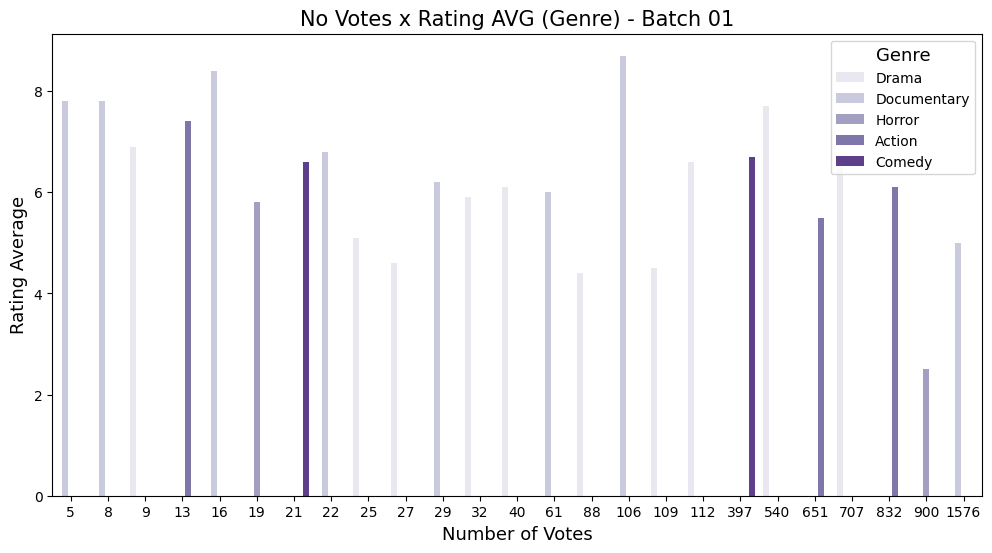

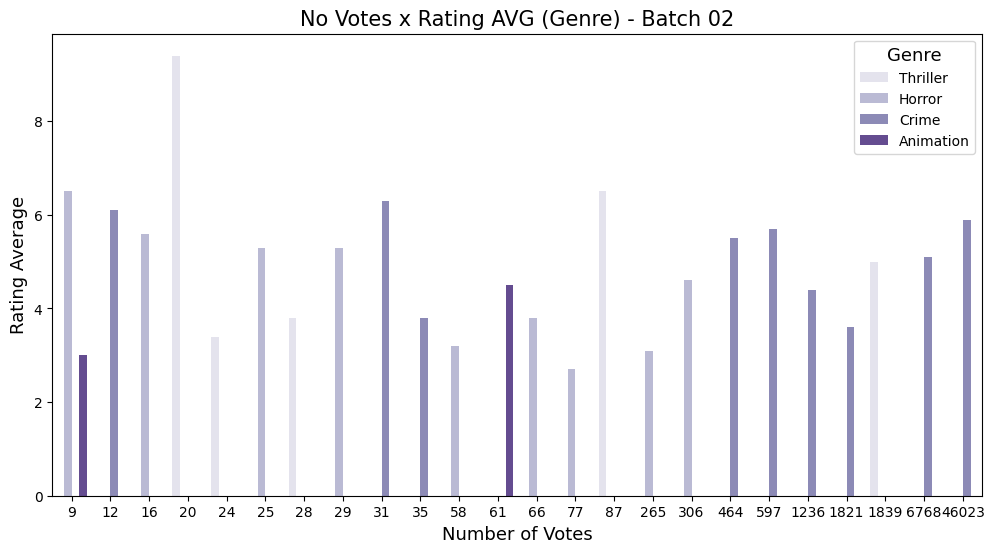

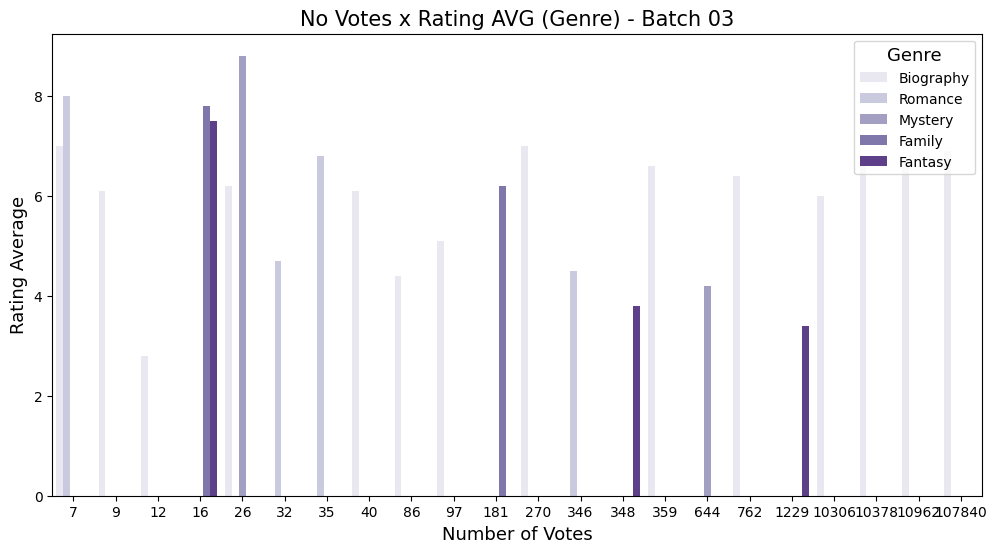

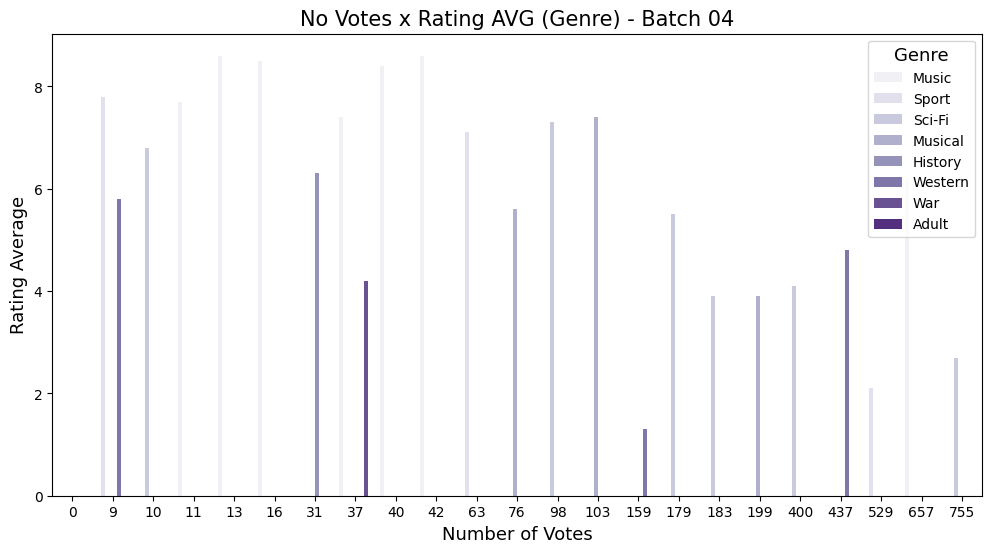

In [10]:
# Question: What is the relationship of "Number of votes" and "Rating Average" ?

# filter by 5 genres
df_train_batch_01 = df_train.loc[df_train['SRC_GENRE'].isin(['Drama', 'Documentary', 'Comedy', 'Action', 'Horror'])]
df_train_batch_02 = df_train.loc[df_train['SRC_GENRE'].isin(['Horror', 'Crime', 'Adventure', 'Animation', 'Thriller'])]
df_train_batch_03 = df_train.loc[df_train['SRC_GENRE'].isin(['Biography', 'Romance', 'Family','Mystery', 'Fantasy',])]
df_train_batch_04 = df_train.loc[df_train['SRC_GENRE'].isin(['Sci-Fi', 'Music', 'Musical', 'Western','History', 'Sport', 'War', 'Adult', 'Short'])]

# Get random 25 rows for each batch
df_train_batch_01 = df_train_batch_01.sample(n=25, random_state=42)
df_train_batch_02 = df_train_batch_02.sample(n=25, random_state=42)
df_train_batch_03 = df_train_batch_03.sample(n=25, random_state=42)
df_train_batch_04 = df_train_batch_04.sample(n=25, random_state=42)

# Plot for batch 01
plt.figure(figsize=(12,6))
plt.title('No Votes x Rating AVG (Genre) - Batch 01', fontsize=15)
plt.grid(False)
sns.barplot(x='NO_OF_VOTES', y='RATING_AVG', hue='SRC_GENRE', data=df_train_batch_01, palette='Purples')
plt.legend(title='Genre', title_fontsize='13', loc='upper right')
plt.xlabel('Number of Votes', fontsize=13)
plt.ylabel('Rating Average', fontsize=13)
plt.show()

# Plot for batch 02
plt.figure(figsize=(12,6))
plt.title('No Votes x Rating AVG (Genre) - Batch 02', fontsize=15)
plt.grid(False)
sns.barplot(x='NO_OF_VOTES', y='RATING_AVG', hue='SRC_GENRE', data=df_train_batch_02, palette='Purples')
plt.legend(title='Genre', title_fontsize='13', loc='upper right')
plt.xlabel('Number of Votes', fontsize=13)
plt.ylabel('Rating Average', fontsize=13)
plt.show()

# Plot for batch 03
plt.figure(figsize=(12,6))
plt.title('No Votes x Rating AVG (Genre) - Batch 03', fontsize=15)
plt.grid(False)
sns.barplot(x='NO_OF_VOTES', y='RATING_AVG', hue='SRC_GENRE', data=df_train_batch_03, palette='Purples')
plt.legend(title='Genre', title_fontsize='13', loc='upper right')
plt.xlabel('Number of Votes', fontsize=13)
plt.ylabel('Rating Average', fontsize=13)
plt.show()

# Plot for batch 04
plt.figure(figsize=(12,6))
plt.title('No Votes x Rating AVG (Genre) - Batch 04', fontsize=15)
plt.grid(False)
sns.barplot(x='NO_OF_VOTES', y='RATING_AVG', hue='SRC_GENRE', data=df_train_batch_04, palette='Purples')
plt.legend(title='Genre', title_fontsize='13', loc='upper right')
plt.xlabel('Number of Votes', fontsize=13)
plt.ylabel('Rating Average', fontsize=13)
plt.show()

# Summary of values for each batch

In [11]:
# Calculate mean votes and ratings for each genre in each batch
mean_votes_batch_01 = df_train_batch_01.groupby('SRC_GENRE')['NO_OF_VOTES'].mean()
mean_ratings_batch_01 = df_train_batch_01.groupby('SRC_GENRE')['RATING_AVG'].mean()

mean_votes_batch_02 = df_train_batch_02.groupby('SRC_GENRE')['NO_OF_VOTES'].mean()
mean_ratings_batch_02 = df_train_batch_02.groupby('SRC_GENRE')['RATING_AVG'].mean()

mean_votes_batch_03 = df_train_batch_03.groupby('SRC_GENRE')['NO_OF_VOTES'].mean()
mean_ratings_batch_03 = df_train_batch_03.groupby('SRC_GENRE')['RATING_AVG'].mean()

mean_votes_batch_04 = df_train_batch_04.groupby('SRC_GENRE')['NO_OF_VOTES'].mean()
mean_ratings_batch_04 = df_train_batch_04.groupby('SRC_GENRE')['RATING_AVG'].mean()

# Find genres with highest mean votes and ratings for each batch
top_voted_genre_batch_01 = mean_votes_batch_01.idxmax()
top_rated_genre_batch_01 = mean_ratings_batch_01.idxmax()

top_voted_genre_batch_02 = mean_votes_batch_02.idxmax()
top_rated_genre_batch_02 = mean_ratings_batch_02.idxmax()

top_voted_genre_batch_03 = mean_votes_batch_03.idxmax()
top_rated_genre_batch_03 = mean_ratings_batch_03.idxmax()

top_voted_genre_batch_04 = mean_votes_batch_04.idxmax()
top_rated_genre_batch_04 = mean_ratings_batch_04.idxmax()

# Display analysis for each batch
print("Analysis for Batch 01:")
print("Genre with highest mean votes:", top_voted_genre_batch_01)
print("Genre with highest mean rating:", top_rated_genre_batch_01)
print("\nAnalysis for Batch 02:")
print("Genre with highest mean votes:", top_voted_genre_batch_02)
print("Genre with highest mean rating:", top_rated_genre_batch_02)
print("\nAnalysis for Batch 03:")
print("Genre with highest mean votes:", top_voted_genre_batch_03)
print("Genre with highest mean rating:", top_rated_genre_batch_03)
print("\nAnalysis for Batch 04:")
print("Genre with highest mean votes:", top_voted_genre_batch_04)
print("Genre with highest mean rating:", top_rated_genre_batch_04)


Analysis for Batch 01:
Genre with highest mean votes: Action
Genre with highest mean rating: Documentary

Analysis for Batch 02:
Genre with highest mean votes: Crime
Genre with highest mean rating: Thriller

Analysis for Batch 03:
Genre with highest mean votes: Biography
Genre with highest mean rating: Family

Analysis for Batch 04:
Genre with highest mean votes: Sci-Fi
Genre with highest mean rating: Music


<br>
<br>

In my  statistical analysis of genre preferences across batches, intriguing patterns emerge. While Action films command the highest mean votes in Batch 01, indicating robust audience engagement, the Documentary genre stands out for its consistently high ratings, suggesting a penchant for thought-provoking narratives. In Batch 02, Crime films attract significant viewer attention, reflected in their top-ranking mean votes, while Thrillers captivate with their compelling storylines, earning the highest average ratings. Moving to Batch 03, Biographical works draw substantial viewer interest, as evidenced by their leading mean votes, while Family-oriented films shine with their exceptional average ratings, resonating deeply with audiences. Lastly, in Batch 04, Sci-Fi movies captivate viewers, garnering the highest mean votes, underscoring the enduring fascination with futuristic narratives, while the Music genre delights with its top-rated performances, signaling an appreciation for musical storytelling. These findings shed light on the diverse preferences and nuanced audience perceptions that shape the cinematic landscape across different genres and batches.

<br>
<br>


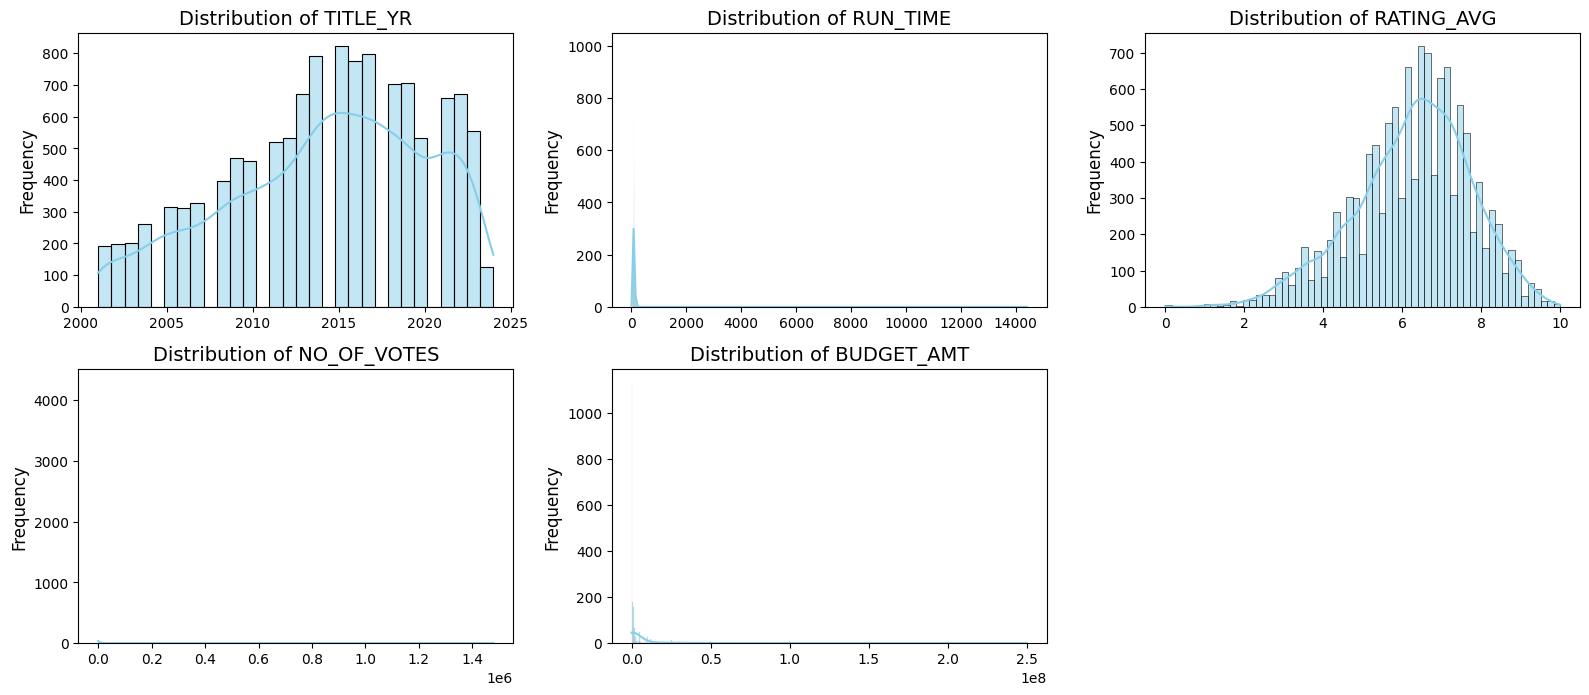

In [12]:
# analysis on data distribution of features

# select only the numerical features from the DataFrame, excluding the 'ID' column
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'])


plt.figure(figsize=(16, 10))

# Plot the distribution of each numerical feature
for i, column in enumerate(numeric_features.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=numeric_features, x=column, kde=True, color='skyblue')
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel('')
    plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
# selecting only the numerical features from the DataFrame, excluding the 'ID' column
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'])

# get descriptive statistics for each numerical feature
statistics = numeric_features.describe()
print(statistics)

           TITLE_YR      RUN_TIME    RATING_AVG   NO_OF_VOTES    BUDGET_AMT
count  12000.000000  11218.000000  12000.000000  1.200000e+04  2.215000e+03
mean    2014.280250     95.859244      6.265383  4.511551e+03  6.983481e+06
std        5.809678    137.131605      1.474281  3.493058e+04  2.254420e+07
min     2001.000000     10.000000      0.000000  0.000000e+00  0.000000e+00
25%     2010.000000     82.000000      5.400000  2.300000e+01  4.000000e+04
50%     2015.000000     92.000000      6.400000  9.200000e+01  3.000000e+05
75%     2019.000000    105.000000      7.300000  4.812500e+02  2.000000e+06
max     2024.000000  14400.000000     10.000000  1.478675e+06  2.500000e+08


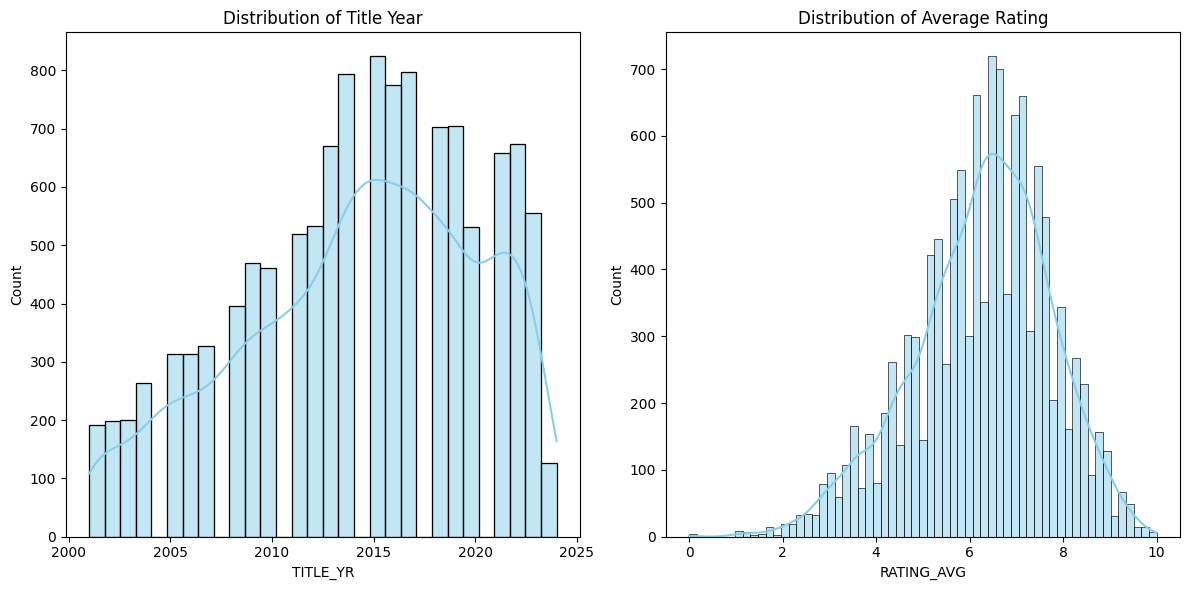

In [14]:
# filtering just "TITLE_YR" and "RATING_AVG" distributions

# set the color palette
#sns.set_palette("coolwarm")

# create subplots
plt.figure(figsize=(12, 6))

# plot distribution of "TITLE_YR"
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='TITLE_YR', kde=True, color="skyblue")
plt.title('Distribution of Title Year')

# plot distribution of "RATING_AVG"
plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='RATING_AVG', kde=True, color="skyblue")
plt.title('Distribution of Average Rating')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

<br>

In analyzing the statistics for "TITLE_YR" and "RATING_AVG," I've gained several insights:

- Title Year (TITLE_YR):

The dataset spans from 2001 to 2024, with the mean year being approximately 2014.28.
With a standard deviation of 5.81, there's a moderate spread of years around the mean.
The majority of movies fall within the range of 2010 to 2019, as indicated by the interquartile range (25th to 75th percentiles).

<br>


- Average Rating (RATING_AVG):

Across all movies, the average rating is approximately 6.27, with a standard deviation of 1.47.
Ratings range from 0 to 10, and the median (50th percentile) rating is 6.4, suggesting a slightly right-skewed distribution.
The interquartile range (25th to 75th percentiles) for ratings spans from 5.4 to 7.3, indicating that the majority of ratings fall within this range.
These statistics offer me valuable insights into the distribution of movie release years and average ratings in my dataset. Further analysis, such as visualizations or hypothesis testing, could provide deeper understanding and potentially uncover additional patterns or trends within the data.

<br>
<br>

In [15]:
# Question: How similar are the text in PLOT's columns ?


# filter the DataFrame to get 10 samples of each genre
genre_samples = {}
for genre in df_train['SRC_GENRE'].unique():
    genre_samples[genre] = df_train[df_train['SRC_GENRE'] == genre]['PLOT_SUMMARY'].head(10).tolist()

# calculate pairwise similarities between samples of the same genre
similarities = []

for genre, samples in genre_samples.items():
    # vectorize the texts using TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(samples)

    # calculate cosine similarity between all pairs of texts
    cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # convert the similarity matrix into a DataFrame
    similarity_df = pd.DataFrame(cosine_similarities, columns=[f"{genre}_{i}" for i in range(len(samples))])

    # append the similarity DataFrame to the list
    similarities.append(similarity_df)

# concatenate all similarity DataFrames along the columns (axis=1)
similarity_matrix = pd.concat(similarities, axis=1)

# calculate the average similarity across all pairs
average_similarity = similarity_matrix.mean().mean()

print("Pairwise Similarity Matrix:")
print(similarity_matrix)
print("\nAverage Similarity:", average_similarity)


Pairwise Similarity Matrix:
   Comedy_0  Comedy_1  Comedy_2  Comedy_3  Comedy_4  Comedy_5  Comedy_6  \
0  1.000000  0.160813  0.078076  0.093643  0.124866  0.184284  0.089445   
1  0.160813  1.000000  0.006396  0.058531  0.161334  0.273874  0.134542   
2  0.078076  0.006396  1.000000  0.036234  0.021057  0.008045  0.030123   
3  0.093643  0.058531  0.036234  1.000000  0.171897  0.065204  0.048126   
4  0.124866  0.161334  0.021057  0.171897  1.000000  0.203430  0.106506   
5  0.184284  0.273874  0.008045  0.065204  0.203430  1.000000  0.161376   
6  0.089445  0.134542  0.030123  0.048126  0.106506  0.161376  1.000000   
7  0.196500  0.188951  0.008896  0.061726  0.189762  0.344004  0.113633   
8  0.076886  0.042942  0.048679  0.090655  0.048337  0.056142  0.000000   
9  0.084471  0.102411  0.022726  0.055628  0.099183  0.135083  0.108828   

   Comedy_7  Comedy_8  Comedy_9  ...  Western_1  Western_2  Western_3  \
0  0.196500  0.076886  0.084471  ...   0.074016   0.109874   0.015679   


<br>
<br>

The cosine similarity value ranges from -1 to 1. Here's the meaning of different value ranges:

- Perfect Similarity (1): It means that the text vectors are identical, i.e., the texts are the same.

- Zero Similarity (0): It indicates that the text vectors are orthogonal, i.e., the texts have nothing in common.

- Negative Similarity (-1): It indicates that the text vectors are opposite, i.e., the texts are completely different and have nothing in common.
Generally, the higher the cosine similarity value (closer to 1), the greater the similarity between the texts. Conversely, values close to 0 indicate little or no similarity, while negative values indicate dissimilarity.

<br>

<b>About the Text Similarity Analysis</b>:

In examining the movie summaries across various genres, I found an average cosine similarity of 0.1917, indicating notable diversity among genre summaries. This highlights the distinct themes and storytelling approaches inherent to each genre. For instance, dramas often delve into intricate character studies and emotional depth, while comedies prioritize humor and light-hearted narratives. On the other hand, action films typically feature high-stakes conflicts and thrilling sequences, contrasting with the introspective exploration of societal issues in documentaries.

This analysis holds significant importance for several reasons. Firstly, it provides insights into audience expectations and preferences for different genres, allowing content creators like myself to tailor productions to specific target audiences effectively. Additionally, it aids in genre classification and recommendation systems, enriching user experience on streaming platforms. Moreover, it serves as a valuable tool for market research within the entertainment industry, guiding strategic decisions regarding content development and distribution.

Overall, this textual analysis underscores the nuanced diversity across genres and its profound impact on audience engagement and content consumption patterns.




<br>
<br>


In [16]:
df_train["SRC_TITLE_ID"]

0         tt7831076
1        tt14746344
2        tt15670842
3        tt14833900
4        tt10495074
            ...    
11995    tt28504359
11996     tt4885814
11997    tt15528116
11998     tt1355568
11999     tt2934344
Name: SRC_TITLE_ID, Length: 12000, dtype: object

Pearson Correlation Matrix:
             TITLE_YR  RUN_TIME  RATING_AVG  NO_OF_VOTES  BUDGET_AMT
TITLE_YR     1.000000 -0.003436    0.048583    -0.013515    0.011319
RUN_TIME    -0.003436  1.000000   -0.007910     0.018302    0.335764
RATING_AVG   0.048583 -0.007910    1.000000     0.044269    0.014559
NO_OF_VOTES -0.013515  0.018302    0.044269     1.000000    0.621509
BUDGET_AMT   0.011319  0.335764    0.014559     0.621509    1.000000






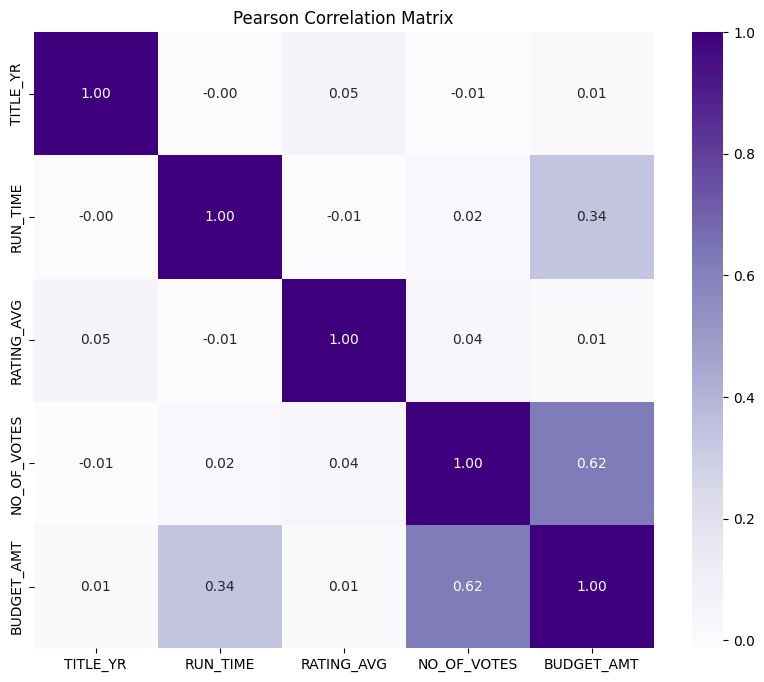

In [17]:
# filter only numeric variables
numeric_df = df_train.select_dtypes(include='number').drop(columns=['ID'])

# calculate the Pearson correlation matrix
correlation_matrix = numeric_df.corr(method='pearson')
print("Pearson Correlation Matrix:")
print(correlation_matrix)
print("\n\n\n")

# plot the heatmap of the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Purples', fmt=".2f", annot_kws={"size": 10})
plt.title('Pearson Correlation Matrix')
plt.show()

<br>
<br>

Pearson correlation coefficient measures the linear relationship between two continuous variables. It ranges from -1 to 1, where 1 indicates a perfect positive linear relationship, -1 indicates a perfect negative linear relationship, and 0 indicates no linear relationship.

Utilizing Pearson correlation in analysis is crucial as it helps identify features strongly related to each other. This knowledge is valuable in various ways. Firstly, it enables us to identify redundant or highly correlated features, which can lead to multicollinearity issues in regression models, thereby impacting model interpretability and stability. Secondly, removing such features can enhance model performance by reducing overfitting and simplifying the model's complexity.

In machine learning, this is particularly important. By eliminating highly correlated features, we can improve model generalization and prevent the model from focusing too heavily on one aspect of the data, leading to more robust and accurate predictions.

In my analysis, the highest correlation coefficient was found between the number of votes and the budget amount, with a correlation coefficient of 0.62. This suggests a moderately strong positive linear relationship between these two variables. While such correlation is not unusual, it's essential to consider whether including both features in a model would provide additional predictive power or if one could be omitted to reduce complexity without sacrificing performance.


<br>

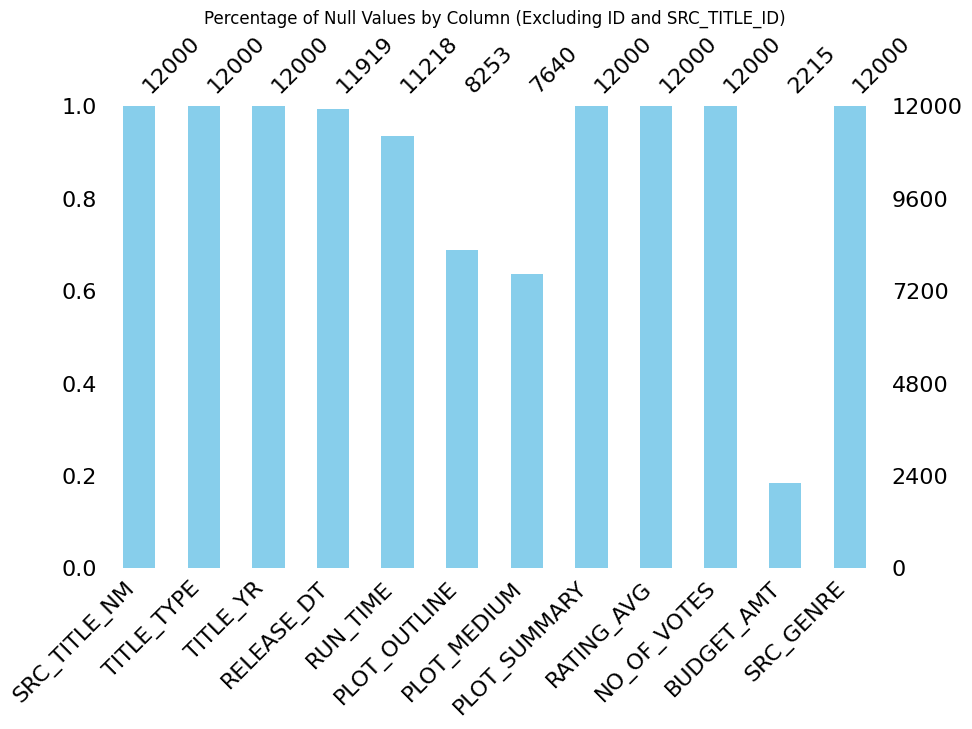

In [18]:
# Question: What is the percentage of null values ?


# remove the 'ID' and 'SRC_TITLE_ID' columns
df_missing_values = df_train.drop(columns=['ID', 'SRC_TITLE_ID'])

# visualize the percentage of null values by column
msno.bar(df_missing_values, figsize=(10, 6), color='skyblue')
plt.title('Percentage of Null Values by Column (Excluding ID and SRC_TITLE_ID)')
plt.show()

In [19]:
# calculate the percentage of null values by column
null_percentage = (df_missing_values.isnull().sum() / len(df_missing_values)) * 100
print(null_percentage)

SRC_TITLE_NM     0.000000
TITLE_TYPE       0.000000
TITLE_YR         0.000000
RELEASE_DT       0.675000
RUN_TIME         6.516667
PLOT_OUTLINE    31.225000
PLOT_MEDIUM     36.333333
PLOT_SUMMARY     0.000000
RATING_AVG       0.000000
NO_OF_VOTES      0.000000
BUDGET_AMT      81.541667
SRC_GENRE        0.000000
dtype: float64


<br>
<br>

The analysis of missing values in our dataset reveals several important insights. While most columns have minimal or no missing values, some columns exhibit a significant percentage of missing data.

The 'BUDGET_AMT' column stands out with an astonishing 81.54% of missing values, indicating a substantial lack of information in this aspect. This missingness might stem from various factors, such as incomplete data collection or unavailability of budget information for certain movies. Given the high proportion of missing values in this column, imputation techniques or alternative strategies may be necessary to handle this missing data effectively.

Similarly, the 'PLOT_MEDIUM' and 'PLOT_OUTLINE' columns show relatively high percentages of missing values, with 36.33% and 31.23%, respectively. These columns contain textual data, such as plot outlines and mediums, which might not always be available or documented for every movie. While it's common for such textual data to have missing values, their presence can pose challenges in natural language processing tasks or sentiment analysis. Careful consideration and preprocessing techniques may be required to address these missing values appropriately.

On the other hand, columns like 'SRC_TITLE_NM', 'TITLE_TYPE', 'TITLE_YR', 'PLOT_SUMMARY', 'RATING_AVG', and 'NO_OF_VOTES' exhibit no missing values or negligible percentages. These columns provide critical information about the movie titles, release years, ratings, and genres, which are essential for various analytical tasks. Their completeness ensures a solid foundation for subsequent analyses and modeling.


<br>
<br>
<hr>
<br>
<br>
<br>

### 2. Feature Engineering


<br>



Feature engineering is a crucial step in data science, as it involves transforming raw data into meaningful features that enhance the performance and interpretability of machine learning models. In this step, I'll be removing missing values, scaling features, selecting relevant features, and more to optimize the predictive power of the models.

Removing missing values is essential as they can introduce biases and errors into the model if left unaddressed. By carefully handling missing data through techniques like imputation or deletion, I ensure the integrity and reliability of the dataset.

Scaling features is another critical aspect of feature engineering, particularly when dealing with algorithms sensitive to feature magnitudes, such as gradient descent-based methods. Scaling ensures that all features contribute equally to the model's learning process, preventing certain features from dominating others.

Feature selection is about identifying the most relevant and informative features for prediction while discarding redundant or irrelevant ones. This process helps simplify the model, reduce overfitting, and improve interpretability.


I'm going to preprocess the dataframe to train a machine learning model





<br>
<br>
<br>







In [20]:
# number of missing values
df_train.isnull().sum()

ID                 0
SRC_TITLE_ID       0
SRC_TITLE_NM       0
TITLE_TYPE         0
TITLE_YR           0
RELEASE_DT        81
RUN_TIME         782
PLOT_OUTLINE    3747
PLOT_MEDIUM     4360
PLOT_SUMMARY       0
RATING_AVG         0
NO_OF_VOTES        0
BUDGET_AMT      9785
SRC_GENRE          0
dtype: int64

In [21]:
# removing not useful features
df_train = df_train.drop(columns=['ID', 'SRC_TITLE_ID', 'RELEASE_DT', 'TITLE_YR', 'TITLE_TYPE', 'PLOT_OUTLINE', "PLOT_MEDIUM"])
df_test = df_test.drop(columns=['ID', 'SRC_TITLE_ID', 'RELEASE_DT', 'TITLE_YR', 'TITLE_TYPE', 'PLOT_OUTLINE', "PLOT_MEDIUM"])

df_train.columns

Index(['SRC_TITLE_NM', 'RUN_TIME', 'PLOT_SUMMARY', 'RATING_AVG', 'NO_OF_VOTES',
       'BUDGET_AMT', 'SRC_GENRE'],
      dtype='object')

In [22]:
df_test.isnull().sum()

SRC_TITLE_NM       0
RUN_TIME         737
PLOT_SUMMARY       0
RATING_AVG         0
NO_OF_VOTES        0
BUDGET_AMT      9856
dtype: int64

In [23]:
# calculate the mean by genre in the 'BUDGET_AMT' column
genre_budget_mean = df_train.groupby('SRC_GENRE')['BUDGET_AMT'].mean()
genre_runtime_mean = df_train.groupby('SRC_GENRE')['RUN_TIME'].mean()

budget_mean = df_train['BUDGET_AMT'].mean()
runtime_mean = df_train['RUN_TIME'].mean()


# fill missing values in the 'BUDGET_AMT' column with the corresponding means by genre
df_train['BUDGET_AMT'] = df_train.apply(lambda row: genre_budget_mean[row['SRC_GENRE']] if pd.isnull(row['BUDGET_AMT']) else row['BUDGET_AMT'], axis=1)
df_train['RUN_TIME'] = df_train.apply(lambda row: genre_runtime_mean[row['SRC_GENRE']] if pd.isnull(row['RUN_TIME']) else row['RUN_TIME'], axis=1)

# Fill missing values in the 'BUDGET_AMT' column with the mean
df_test['BUDGET_AMT'].fillna(budget_mean, inplace=True)
df_test['RUN_TIME'].fillna(runtime_mean, inplace=True)

In [24]:
# dataframe without missing values
df_train.isnull().sum()

SRC_TITLE_NM    0
RUN_TIME        0
PLOT_SUMMARY    0
RATING_AVG      0
NO_OF_VOTES     0
BUDGET_AMT      0
SRC_GENRE       0
dtype: int64

In [25]:
df_train.dtypes

SRC_TITLE_NM     object
RUN_TIME        float64
PLOT_SUMMARY     object
RATING_AVG      float64
NO_OF_VOTES       int64
BUDGET_AMT      float64
SRC_GENRE        object
dtype: object

In [26]:
# select the numerical features you want to scale
numerical_features = ['RUN_TIME', 'RATING_AVG', 'NO_OF_VOTES', 'BUDGET_AMT']

# initialize the StandardScaler
scaler = StandardScaler()

# fit and transform the selected numerical features
df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])

In [27]:
df_train.dtypes

SRC_TITLE_NM     object
RUN_TIME        float64
PLOT_SUMMARY     object
RATING_AVG      float64
NO_OF_VOTES     float64
BUDGET_AMT      float64
SRC_GENRE        object
dtype: object

In [28]:
# label encoder
label_encoder = LabelEncoder()
df_train['SRC_GENRE'] = label_encoder.fit_transform(df_train['SRC_GENRE'])
df_train['SRC_TITLE_NM'] = df_train['SRC_TITLE_NM'].astype(str)
df_train['PLOT_SUMMARY'] = df_train['PLOT_SUMMARY'].astype(str)


df_test["SRC_TITLE_NM"] = df_test["SRC_TITLE_NM"].astype(str)
df_test["PLOT_SUMMARY"] = df_test["PLOT_SUMMARY"].astype(str)

In [29]:
# initialize target encoder
target_encoder = TargetEncoder()
label_encoder_test_set = LabelEncoder()

# apply
df_train["SRC_TITLE_NM"] = target_encoder.fit_transform(df_train['SRC_TITLE_NM'].values.reshape(-1, 1), df_train["SRC_GENRE"])
df_train["PLOT_SUMMARY"] = target_encoder.fit_transform(df_train['PLOT_SUMMARY'].values.reshape(-1, 1), df_train["SRC_GENRE"])

df_test["SRC_TITLE_NM"] = label_encoder_test_set.fit_transform(df_test["SRC_TITLE_NM"])
df_test["PLOT_SUMMARY"] = label_encoder_test_set.fit_transform(df_test["PLOT_SUMMARY"])

In [30]:
df_train.head()

,SRC_TITLE_NM,RUN_TIME,PLOT_SUMMARY,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,SRC_GENRE
0,0.093333,0.113948,0.093333,-3.300311,-0.125527,-0.058404,5
1,0.093333,-0.051973,0.093333,-1.333169,-0.127130,-0.496107,12
2,0.093333,0.076239,0.093333,-1.061839,-0.128905,1.451385,0
3,0.093333,0.061155,0.093333,-0.180016,-0.126529,-0.211307,8
4,0.093333,0.038529,0.093333,0.362644,-0.128705,0.298307,2


In [31]:
df_test.head()

,SRC_TITLE_NM,RUN_TIME,PLOT_SUMMARY,RATING_AVG,NO_OF_VOTES,BUDGET_AMT
0,950,0.061155,7949,-0.519179,-0.110096,0.087129
1,8853,-0.074599,7387,-0.247849,-0.128676,-0.498961
2,1352,0.068697,6948,-0.926174,-0.118971,-0.498205
3,1043,0.211993,4147,-0.926174,-0.128190,0.087129
4,3057,-0.067057,7194,-0.587011,-0.125040,0.087129


<br>
<br>

In my analysis, I made the decision to remove the "PLOT_OUTLINE" and "PLOT_MEDIUM" columns from consideration due to the substantial number of missing values and the striking similarity between them. These columns exhibited high rates of missing data, which would have compromised the integrity of any analysis conducted using them. Furthermore, upon inspection, it became apparent that the textual content in these columns often overlapped significantly, suggesting redundancy in their inclusion.

Conversely, I chose to retain the "PLOT_SUMMARY" column, recognizing its potential value in capturing concise and informative descriptions of movie plots. To address missing values within this column, I employed a strategy based on the mean values specific to each movie genre. By leveraging the mean of available data within each genre category, I aimed to maintain the integrity of the dataset while minimizing the impact of missing information.

Ultimately, this decision was motivated by a desire to streamline the dataset, focusing on the most informative features while mitigating the effects of missing data. By prioritizing columns with higher data integrity and relevance, I aimed to optimize the quality of subsequent analyses and modeling efforts.



<br>
<hr>
<br>
<br>


### 3. Machine learning model


<br>

In [32]:
df_train.columns

Index(['SRC_TITLE_NM', 'RUN_TIME', 'PLOT_SUMMARY', 'RATING_AVG', 'NO_OF_VOTES',
       'BUDGET_AMT', 'SRC_GENRE'],
      dtype='object')

In [33]:
X = df_train.drop('SRC_GENRE', axis=1)
y = df_train['SRC_GENRE']

In [34]:
# Validation
KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 0
for train_index, test_index in KFold.split(X, y):
    fold += 1
    print('Fold: ', fold)
    print('Training: ', len(train_index))
    print('Testing: ', len(test_index))

    # Splitting data manually
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Creating model
    params = {
        'iterations': 200,  # Number of iterations (trees) in the model
        'learning_rate': 0.03,  # Learning rate of the model
        'depth': 6,  # Maximum depth of the trees
        'l2_leaf_reg': 3,  # L2 regularization
        'border_count': 32,  # Number of bins for numerical values
        'thread_count': -1,  # Number of threads for training (-1 uses all available cores)
        'random_seed': 42,  # Random seed for reproducibility
        'eval_metric': 'Accuracy',  # Evaluation metric during training
        'verbose': False  # Controls the verbosity of the model during training
    }

    catboost_clf = CatBoostClassifier(**params)
    catboost_clf.fit(X_train, y_train)
    y_pred = catboost_clf.predict(X_test)

    # Metrics
    print('\n')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average='weighted'))
    print('Recall:', recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))
    print('--------------'*5)
    print('\n')

Fold:  1
Training:  9600
Testing:  2400


Accuracy: 0.8591666666666666
Precision: 0.8519921317854442
Recall: 0.8591666666666666
F1 Score: 0.8502094698606621
----------------------------------------------------------------------


Fold:  2
Training:  9600
Testing:  2400


Accuracy: 0.8458333333333333
Precision: 0.8356768615265444
Recall: 0.8458333333333333
F1 Score: 0.8351527900889806
----------------------------------------------------------------------


Fold:  3
Training:  9600
Testing:  2400


Accuracy: 0.8541666666666666
Precision: 0.8444176646574479
Recall: 0.8541666666666666
F1 Score: 0.8450412860199323
----------------------------------------------------------------------


Fold:  4
Training:  9600
Testing:  2400


Accuracy: 0.8558333333333333
Precision: 0.8454379278246241
Recall: 0.8558333333333333
F1 Score: 0.8456946766764953
----------------------------------------------------------------------


Fold:  5
Training:  9600
Testing:  2400


Accuracy: 0.86125
Precision: 0.8463633

<br>
<br>



Cross-validation is a robust technique used to assess the performance of machine learning models. In this approach, the dataset is split into multiple subsets, or folds, allowing the model to be trained and evaluated multiple times. Each fold serves alternately as the validation set while the rest are used for training. This process helps to provide a more reliable estimate of the model's performance by reducing the variability associated with a single train-test split.

CatBoost, being a gradient boosting algorithm, is particularly well-suited for cross-validation. It naturally handles complex relationships in the data and has built-in support for categorical features, which often occur in real-world datasets. Additionally, CatBoost's efficient implementation and ability to automatically handle missing values make it a strong contender for cross-validation tasks.

In the context of training a CatBoost model, splitting the dataset into training and testing subsets is essential to evaluate the model's performance on unseen data. By reserving a portion of the data for testing, we can assess how well the model generalizes to new observations, helping to identify potential overfitting or underfitting issues.

Overall, leveraging cross-validation with CatBoost allows us to make more informed decisions about model selection, hyperparameter tuning, and generalization performance, leading to more reliable and robust machine learning models.


<br>
<hr>
<br>
<br>
<br>


### 4. Inference


The inference section is a crucial step where we test the trained model on a separate test dataset to evaluate its performance and generalization ability. In this section, we deploy the model to make predictions on unseen data and assess its effectiveness in real-world scenarios. Here's an overview of what typically happens in the inference section:


<br>
<br>

In [35]:
X_test = df_test
X_test.head(), X_test.shape

(   SRC_TITLE_NM  RUN_TIME  PLOT_SUMMARY  RATING_AVG  NO_OF_VOTES  BUDGET_AMT
 0           950  0.061155          7949   -0.519179    -0.110096    0.087129
 1          8853 -0.074599          7387   -0.247849    -0.128676   -0.498961
 2          1352  0.068697          6948   -0.926174    -0.118971   -0.498205
 3          1043  0.211993          4147   -0.926174    -0.128190    0.087129
 4          3057 -0.067057          7194   -0.587011    -0.125040    0.087129,
 (12000, 6))

In [36]:
# inference in test set
predictions = catboost_clf.predict(X_test)

In [37]:
# add results in dataframe
df_test['predictions'] = predictions

In [38]:
df_test.head()

,SRC_TITLE_NM,RUN_TIME,PLOT_SUMMARY,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,predictions
0,950,0.061155,7949,-0.519179,-0.110096,0.087129,5
1,8853,-0.074599,7387,-0.247849,-0.128676,-0.498961,5
2,1352,0.068697,6948,-0.926174,-0.118971,-0.498205,12
3,1043,0.211993,4147,-0.926174,-0.128190,0.087129,5
4,3057,-0.067057,7194,-0.587011,-0.125040,0.087129,5


In [39]:
y_pred_names = label_encoder.inverse_transform(predictions)

In [40]:
y_pred_names

array(['Comedy', 'Comedy', 'Horror', ..., 'Thriller', 'Comedy', 'Comedy'],
      dtype=object)

In [41]:
# create the labels column
predicted_labels = df_test['predictions']
predicted_genre_names = label_encoder.inverse_transform(predicted_labels)
df_test['predicted_genre'] = predicted_genre_names

In [42]:
df_test.head()

,SRC_TITLE_NM,RUN_TIME,PLOT_SUMMARY,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,predictions,predicted_genre
0,950,0.061155,7949,-0.519179,-0.110096,0.087129,5,Comedy
1,8853,-0.074599,7387,-0.247849,-0.128676,-0.498961,5,Comedy
2,1352,0.068697,6948,-0.926174,-0.118971,-0.498205,12,Horror
3,1043,0.211993,4147,-0.926174,-0.128190,0.087129,5,Comedy
4,3057,-0.067057,7194,-0.587011,-0.125040,0.087129,5,Comedy


In [43]:
df_test.to_csv('submission.csv', index=False)

<br>
<br>
<hr>
<br>
<br>

### Conclusion


In conclusion, this challenge provided me with a valuable opportunity to showcase my hard skills in the field of Data Science. From data preprocessing and feature engineering to building and evaluating machine learning models, I aimed to demonstrate a comprehensive understanding of the end-to-end data science process.

Throughout this project, I strived to leverage various techniques and methodologies to extract insights and make informed decisions. While I explored several approaches, I recognize that there are countless other techniques and models to explore. Due to the time constraints of the challenge, I focused on implementing the most relevant strategies and models to address the problem at hand.

I am eager to continue expanding my knowledge and expertise in Data Science by exploring additional techniques, experimenting with different models, and tackling more complex problems. This challenge served as a stepping stone in my journey, and I am grateful to Leonardo Sanchez for providing me with this opportunity.

Thank you for entrusting me with this case, and I look forward to further opportunities to apply my skills and contribute to impactful projects in the future.


Best regards,
Felipe Oliveira

<br>
<br>